# Zonal structure of time-mean SST in the equatorial Pacific

Computes the zonal root mean square error (RMSE) of equatorial Pacific (150°E-90°W) climatological (time and meridional 5°S-5°N average) sea surface temperature (SST) between model and observations

### Observations and reanalysis datasets used for comparison

- **HadISST (1870-2018)**: The Hadley Centre Sea Ice and Sea Surface Temperature dataset offers global monthly SST and sea ice concentration fields, incorporating in-situ and satellite data for climate variability analysis.

### In this recipe this is replaced with an ESM1.6 Spin up

## Dask Cluster 

Start a cluster with multiple cores 

In [1]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39687,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44131,Total threads: 1
Dashboard: /proxy/41113/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:38905,


## Comparison for ESM1.6

- Use ACCESS-MOPPeR interactive API to CMORise required variable. (May take some time)
- Write output to netCDF to read in later in other notebooks too
- or convert to iris cube to tied into recipe

In [ ]:
import glob
from access_mopper import ACCESS_ESM_CMORiser

ROOT_FOLDER = (
    "/g/data/p73/archive/CMIP7/ACCESS-ESM1-6/spinup/JuneSpinUp-JuneSpinUp-bfaa9c5b/"
)

OUTPUT_FOLDER = "/scratch/nf33/fc6164"

In [ ]:
parent_experiment_config = {
    "parent_experiment_id": "piControl",
    "parent_activity_id": "CMIP",
    "parent_source_id": "ACCESS-ESM1-5",
    "parent_variant_label": "r1i1p1f1",
    "parent_time_units": "days since 0001-01-01 00:00:00",
    "parent_mip_era": "CMIP6",
    "branch_time_in_child": 0.0,
    "branch_time_in_parent": 54786.0,
    "branch_method": "standard",
}

In [ ]:
FILES = glob.glob(
    ROOT_FOLDER + "output[0-1][0-9][0-9]/ocean/ocean-2d-surface_temp-1monthly-mean*.nc"
)
len(FILES)
## reduce the years to cmorise by the output folders

In [ ]:
cmoriser = ACCESS_ESM_CMORiser(
    input_paths=FILES,
    compound_name="Omon.tos",
    experiment_id="piControl",
    source_id="ACCESS-ESM1-5",
    variant_label="r1i1p1f1",
    grid_label="gn",
    activity_id="CMIP",
    output_path=OUTPUT_FOLDER,
    parent_info=parent_experiment_config,  # <-- This is optional, can be skipped if not needed
)

In [ ]:
cmoriser.run()
# cmoriser.write()
esm16 = cmoriser.to_iris()

In [ ]:
## if you have other cmorised file already saved out
fp = '/scratch/p66/fc6164/MOPPeR/ts_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_109201-159112.nc'
import iris
esm16_ts = iris.load_cube(fp)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/iris/fileformats/cf.py:664: IrisCfMissingVarWarning: Missing CF-netCDF grid mapping variable 'latitude_longitude', referenced by netCDF variable 'ts'
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/iris/fileformats/cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ts'
  warnings.warn(


## Datasets

In [5]:
from esmvalcore.dataset import Dataset

In [ ]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="piControl",
    ensemble="r1i1p1f1",
    # timerange="18500101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
),
}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    type='reanaly',
    tier=2),
}

## Add Ancillary files

In [7]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [8]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/fx/sftlf/gn/v20210316/sftlf_fx_ACCESS-ESM1-5_piControl_r1i1p1f1_gn.nc)


In [9]:
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import mask_landsea

In [21]:
def prepoc1(cube):
    nino3_ep_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}    
    cube = convert_units(cube, units="degC")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = extract_region(cube, **nino3_ep_region)
    cube = axis_statistics(cube, operator="mean", axis="y")
    return cube

def prepoc2(cube):
    nino3_latext_region = {"start_longitude": 140., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    # cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)
    cube = convert_units(cube, units="degC")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = mask_landsea(cube, mask_out="land") #uses shapefiles, ancVariable, land_area_fraction
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = extract_region(cube, **nino3_latext_region)
    return cube

In [ ]:
model_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in obs_datasets.items()}
esm16_prep1 = prepoc1(esm16)

In [17]:
esm16_prep1.data
rmse = np.sqrt(np.mean((esm16_prep1.data - model_datasets_prep1["ACCESS-ESM1-5"].data) ** 2))
rmse

0.76293135

In [ ]:
model_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in model_datasets.items()}
# obs_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in obs_datasets.items()}
esm16_prep2 = prepoc2(esm16)

# Diagnostics Level 1


In [14]:
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

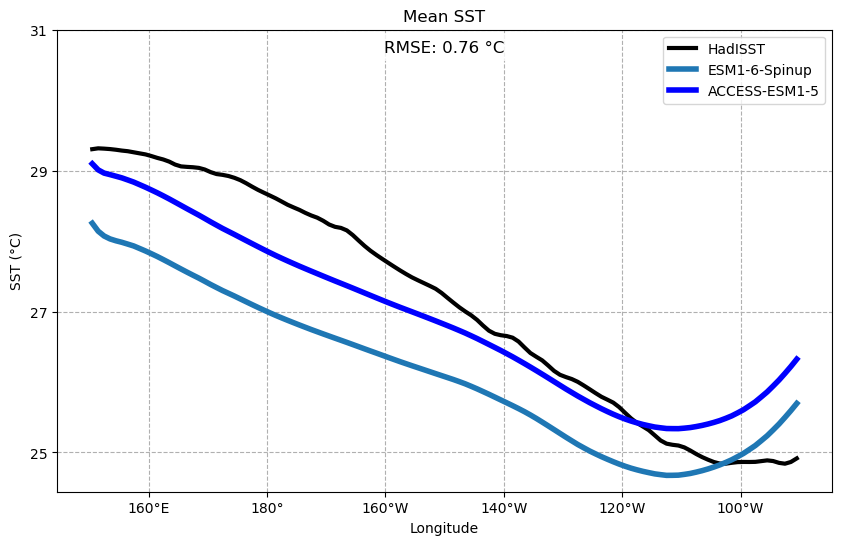

In [ ]:

# Function to format x-axis labels with degree symbols and N/S
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

plt.figure(figsize=(10, 6))

obs_data = obs_datasets_prep1["HadISST"]
model_data = model_datasets_prep1["ACCESS-ESM1-5"]

# Plot observation data in black
qplt.plot(obs_data, color='black', label='HadISST', linewidth=3)

qplt.plot(esm16_prep1, color='tab:blue', label='ESM1-6-Spinup', linewidth=4)

# Plot model data in blue
qplt.plot(model_data, color='blue', label='ACCESS-ESM1-5', linewidth=4)

# rmse = np.sqrt(np.mean((obs_data.data - model_data.data) ** 2))

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('SST (°C)')
plt.title('Mean SST')
plt.grid(linestyle='--')
plt.yticks(np.arange(25,32, step=2))

# Adding RMSE text on top of the plot
plt.text(0.5, 0.95, f'ESM1.6-1.5 RMSE: {rmse:.2f} °C', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Setting custom x-axis formatter
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

# Adding a legend
plt.legend()

# Display the plot
plt.show()

Figure 1: Zonal bias in the sea surface temperature (SST) structure across the equatorial Pacific (averaged between 5°S–5°N), primarily illustrating the cold tongue bias (typically warmer near South America and cooler further west). The black curve represents the reference data, while the blue curve represents the model data. The metric displayed is the zonal RMSE between the model and reference curves.

# Diagnostics Level 2


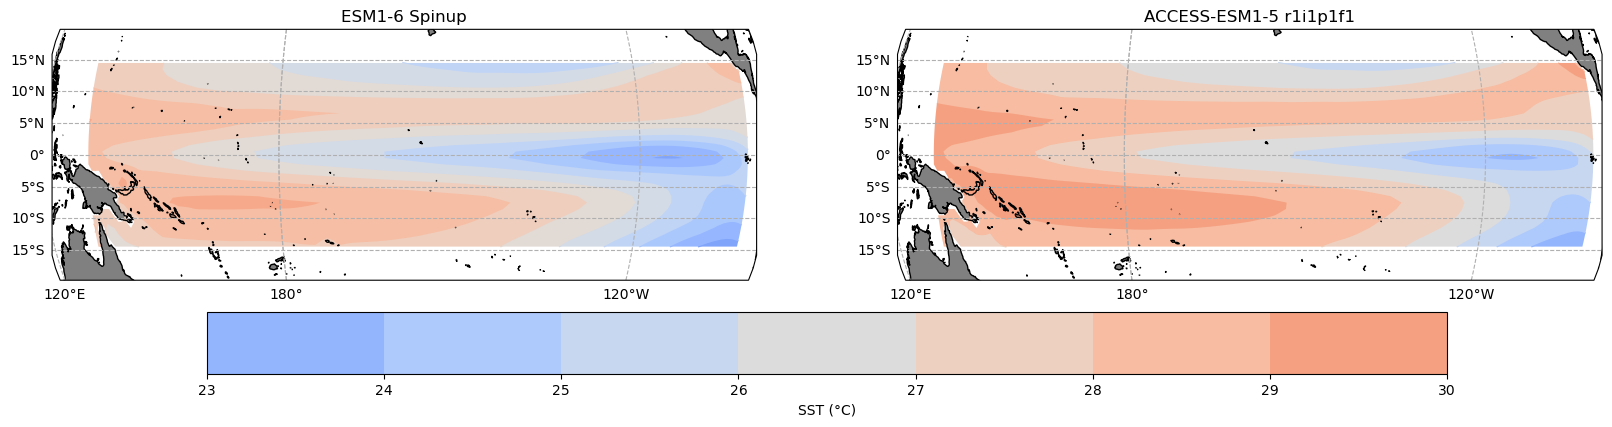

In [27]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Importing numpy for linear space creation
import numpy as np

import iris.plot as iplt

# obs_data = obs_datasets_prep2["HadISST"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

# Use the coolwarm colormap
cmap = plt.get_cmap('coolwarm')

# Create a large figure
fig = plt.figure(figsize=(20, 10))  # Adjusted for full width

# Center the map on the Pacific Ocean (roughly around 180° longitude)
proj = ccrs.Orthographic(central_longitude=-160, central_latitude=0)

# Define the normalization for the color scale with range of 20 to 33°C
norm = mcolors.Normalize(vmin=20, vmax=33)

# Plot #1: contourf with axes longitude from -180 to 180
ax1 = plt.subplot(121, projection=proj)
cf1 = iplt.contourf(esm16_prep2, cmap=cmap, norm=norm)
ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax1.coastlines()
ax1.set_extent([120, -80, -20, 20], crs=ccrs.PlateCarree())
ax1.set_title("ESM1-6 Spinup")

# Add gridlines for latitude and longitude
gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

# Plot #2: contourf with axes longitude from 0 to 360
ax2 = plt.subplot(122, projection=proj)
cf2 = iplt.contourf(model_data, cmap=cmap, norm=norm)
ax2.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax2.coastlines()
ax2.set_extent([120, -80, -20, 20], crs=ccrs.PlateCarree())
ax2.set_title("ACCESS-ESM1-5 r1i1p1f1")

# Add gridlines for latitude and longitude
gl2 = ax2.gridlines(draw_labels=True, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

plt.subplots_adjust(bottom=0.25)  # Further adjust bottom margin to fit the colorbar
# Add a single colorbar at the bottom
cbar = fig.colorbar(cf2, ax=[ax1, ax2], orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('SST (°C)')
#cbar.set_ticks(np.arange(20, 33))  # Set ticks at intervals of 2 degrees

plt.show()


Figure 2: Time-mean sea surface temperature (SST) bias in the equatorial Pacific, primarily highlighting the cold tongue bias (warmer near South America and cooler further west). The left map displays the reference data, and the right map shows the model data.